# 타이타닉 생존자 예측

In [47]:
import pandas as pd 

## 데이터 로드

In [48]:
titanic_df = pd.read_csv('./data/titanic/titanic_train.csv')
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [49]:
print('\n ### 학습 데이터 정보 ### \n')
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## EDA

In [50]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<Axes: xlabel='Sex', ylabel='Survived'>

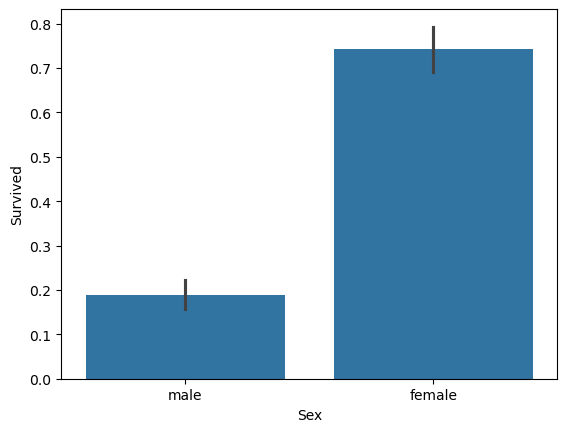

In [52]:
# 성별별 생존률
import seaborn as sns 
sns.barplot(x= 'Sex', y='Survived', data = titanic_df)

<Axes: xlabel='Pclass', ylabel='Survived'>

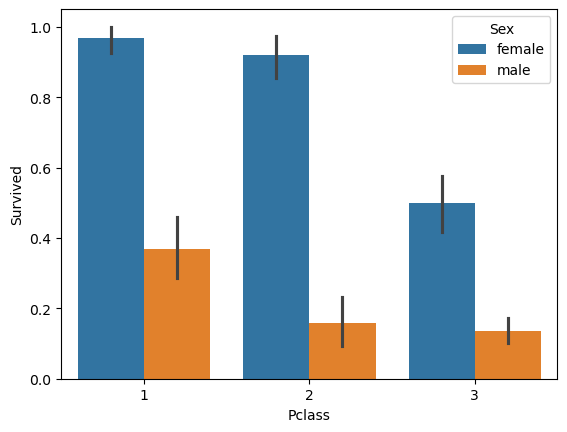

In [54]:
#객실 등급별 생존 확률 
sns.barplot(x = 'Pclass', y = 'Survived', hue= 'Sex', data= titanic_df)

## 전처리

결측치 처리
- Age: 평균값
- Cabin: N
- Embarked: N 

In [12]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
titanic_df['Cabin'].fillna('N', inplace= True)
titanic_df['Embarked'].fillna('N', inplace= True)

print('데이터 셋 null 개수', titanic_df.isnull().sum().sum())

데이터 셋 null 개수 0


/var/folders/_f/zkkpxg4j4j5_dc9281g3t2pr0000gn/T/ipykernel_99799/2634977585.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
/var/folders/_f/zkkpxg4j4j5_dc9281g3t2pr0000gn/T/ipykernel_99799/2634977585.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

필요없는 열 배제 drop
- PassengerId, Name, Ticket

In [13]:
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis= 1)
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,N,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,N,S


Label encoding - 범주형
- Sex, Cabin, Embarked

In [14]:
print('Sex 값 분포:\n', titanic_df['Sex'].value_counts())
print('Cabin 값 분포:\n', titanic_df['Cabin'].value_counts())
print('Embarked 값 분포:\n', titanic_df['Embarked'].value_counts())

Sex 값 분포:
 Sex
male      577
female    314
Name: count, dtype: int64
Cabin 값 분포:
 Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64
Embarked 값 분포:
 Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64


In [15]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [16]:
from sklearn.preprocessing import LabelEncoder

col_names = ['Cabin', 'Sex', 'Embarked']
for col in col_names:
    le = LabelEncoder()
    le.fit(titanic_df[col])
    titanic_df[col] = le.transform(titanic_df[col])
    
titanic_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0


Age, Fare - 수치형

In [18]:
X_titanic_df = titanic_df.drop('Survived', axis=1)
y_titanic_df = titanic_df['Survived']

## 데이터 분할

In [19]:
from sklearn.model_selection import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size= 0.2, random_state= 11)

## 학습

1. DecisionTreeClassifier
2. RandomForestClassifier
3. LogisticRegression

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [22]:
dt_clf = DecisionTreeClassifier(random_state= 11)
rf_clf = RandomForestClassifier(random_state= 11)
lr_clf = LogisticRegression(random_state=11)

In [25]:
import numpy as np 
from sklearn.metrics import accuracy_score

dt_clf.fit(X_train,y_train)
rf_clf.fit(X_train,y_train)
lr_clf.fit(X_train,y_train)

dt_pred = dt_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)

print("DecisionTree 정확도:", np.round(accuracy_score(y_test, dt_pred),4))
print("RandomForest 정확도:", np.round(accuracy_score(y_test, rf_pred),4))
print("LogisticRegression 정확도:", np.round(accuracy_score(y_test, lr_pred),4))

DecisionTree 정확도: 0.7877
RandomForest 정확도: 0.8547
LogisticRegression 정확도: 0.8492


/Users/pakeunseo/opt/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 교차검증

In [27]:
dt_clf_cv = DecisionTreeClassifier(random_state= 11)
rf_clf_cv = RandomForestClassifier(random_state= 11)
lr_clf_cv = LogisticRegression(random_state=11)

In [31]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits= 5)
scores = []

for train_index, test_index in kfold.split(X_titanic_df):
    X_train, X_test = X_titanic_df.values[train_index],  X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    
    dt_clf_cv.fit(X_train, y_train)
    dt_pred = dt_clf_cv.predict(X_test)   
    scores.append(accuracy_score(y_test, dt_pred))

print(scores)    
print('평균 정확도:', np.mean(scores))

[0.7541899441340782, 0.7808988764044944, 0.7865168539325843, 0.7696629213483146, 0.8202247191011236]
평균 정확도: 0.782298662984119


## 파라미터 튜닝 + 교차검증
- GridSearchCV 

In [33]:
dt_clf_gcv = DecisionTreeClassifier(random_state=11)
rf_clf_gcv = RandomForestClassifier(random_state=11)
lr_clf_gcv = LogisticRegression(solver='liblinear')

In [34]:
from sklearn.model_selection import GridSearchCV

#DecisionTree parameter,
 
parameters = { 'max_depth':[1,2,3], 'min_samples_split':[2,3] }
grid_dt_clf = GridSearchCV(dt_clf_gcv, param_grid= parameters, scoring='accuracy', cv=5)
grid_dt_clf.fit(X_train, y_train)

score_df = pd.DataFrame(grid_dt_clf.cv_results_)
score_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000827,0.000517,0.000403,0.000134,1,2,"{'max_depth': 1, 'min_samples_split': 2}",0.804196,0.762238,0.825175,0.774648,0.746479,0.782547,0.028501,3
1,0.000542,0.000094,0.000309,0.000011,1,3,"{'max_depth': 1, 'min_samples_split': 3}",0.804196,0.762238,0.825175,0.774648,0.746479,0.782547,0.028501,3
2,0.000578,0.000034,0.000325,0.000032,2,2,"{'max_depth': 2, 'min_samples_split': 2}",0.748252,0.762238,0.825175,0.774648,0.746479,0.771358,0.028786,5
3,0.000607,0.000037,0.000355,0.000067,2,3,"{'max_depth': 2, 'min_samples_split': 3}",0.748252,0.762238,0.825175,0.774648,0.746479,0.771358,0.028786,5
4,0.000632,0.000017,0.000307,0.000024,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.797203,0.804196,0.818182,0.795775,0.774648,0.798001,0.014118,1
5,0.000601,0.000011,0.000289,0.000004,3,3,"{'max_depth': 3, 'min_samples_split': 3}",0.797203,0.804196,0.818182,0.795775,0.774648,0.798001,0.014118,1


In [38]:
best_dt_clf = grid_dt_clf.best_estimator_
best_dt_pred = best_dt_clf.predict(X_test)
scores = accuracy_score(y_test, best_dt_pred)
print('정확도:', np.round(scores, 4))

정확도: 0.8427


## 정확도 높이기 - 튜닝

- 스케일링, 속성선택 , model: RF, LR, 파라미터